## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. 

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

### Q1. 

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [1]:
import pickle
with open('data/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)
    
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens. 

What do you notice about the frequency of occurrence of different tokens? How does it look?

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

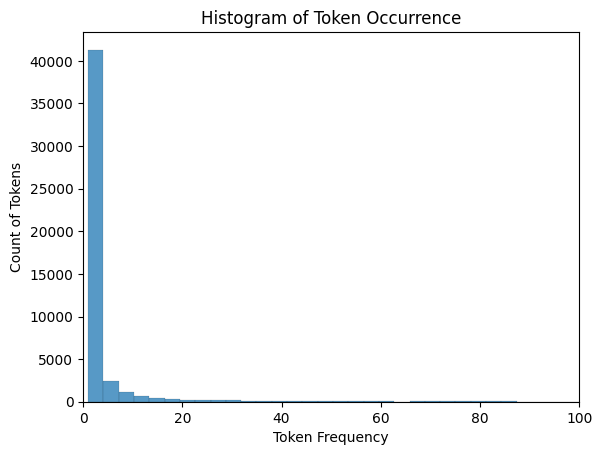

In [3]:
counts = [count for token, count in token_freq]

fig=sns.histplot(counts)
fig.set_xlim(0, 100)
fig.set(title="Histogram of Token Occurrence", xlabel='Token Frequency', ylabel='Count of Tokens')
plt.show()

- The frequency of the token has a exponentially decresing distribution.
- This suggesting that the are a lot of tokens that appears below 5 times and only a few tokens appear more than 40 times. 
---

### Q2. 

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

In [4]:
phish = pd.read_parquet("./data/Phishing_clean.parquet")
phish.head()

,Email Type,new,date,get,please,enron,like,2002,would,one,...,ï¿½ï¿½,safety,yap,ypil,maintain,procedures,tip,elizabeth,leadership,italian
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


1. Perform an 80/20 train-test split of the data.

In [5]:
from sklearn.model_selection import train_test_split # Train/test splitter
from sklearn.linear_model import LinearRegression # Import linear regression model

In [6]:
X = phish.iloc[:, 1:]
y = phish.iloc[:, :1]

# Train-test split:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=100)

2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?

In [7]:
reg = LinearRegression(fit_intercept=False).fit(X_train, y_train) # Fit the linear model
results = pd.DataFrame({'variable':reg.feature_names_in_, 'coefficient': reg.coef_.ravel()}) # Regression coefficients
print('R-squared (training set): ', reg.score(X_train, y_train)) # R squared measure
print('R-squared (test set): ', reg.score(X_test, y_test))
results

R-squared (training set):  0.6976550556220656
R-squared (test set):  0.5654916939884798


,variable,coefficient
0,new,0.073775
1,date,0.066609
2,get,0.078010
3,please,-0.007446
4,enron,-0.179081
...,...,...
2706,procedures,-0.061421
2707,tip,0.070634
2708,elizabeth,-0.090000
2709,leadership,0.037012


- The $R^2$ on the training set is about 69.8%
- The $R^2$ on the test set is about 56.5%

3. What words have the largest coefficients in absolute value and most strongly influence predictions? 

In [8]:
results['abs_coefficient'] = results['coefficient'].abs()
results.sort_values(by='abs_coefficient', ascending=False).head()

,variable,coefficient,abs_coefficient
1504,background-image:,-0.925481,0.925481
2362,thermal,0.911275,0.911275
2532,xanaax,0.871067,0.871067
2701,ï¿½ï¿½,0.864955,0.864955
469,utf,0.704203,0.704203


- "background-image:" and 'thermal' have the largest absolute coefficients (both greater than 0.9) and most strongly influence predictions. 
---

### Q3. 

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

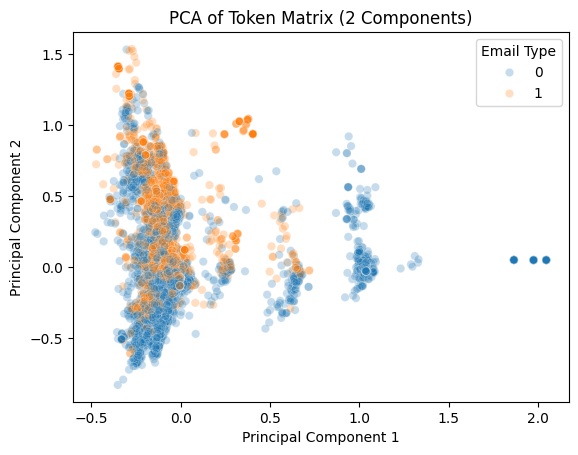

In [9]:
from sklearn.decomposition import PCA # Import PCA class
pca = PCA(n_components = 2) # Create PCA instance
pca = pca.fit(X) # Create the decomposition
Z = pca.transform(X) # Project email data; could use new data or test data

pca_df = pd.DataFrame(Z, columns=['PC1', 'PC2'])
pca_df['Email Type'] = y.values

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Email Type', alpha = 0.25)
plt.title('PCA of Token Matrix (2 Components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


- The phishing scam emails and the non-phishing emails are a bit mixed together, with phishing emails mostly be on the top half of the PC2.
- All the emails seems to be separated into 6 clusters. 
- It looks like as PC1 increases, the phishing emails and the non-phishing emails to be more separated into their own cluster (top vs. bottom), and no phishing emails appeared for PC1>0.75. 
---

### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [10]:
## Extract first 2610 principal component:
pca = PCA(n_components=2610)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [11]:
# Linear regression with pca
reg = LinearRegression().fit(X_train_pca,y_train) # Fit the linear model
print('R-squared (training set): ', reg.score(X_train_pca, y_train)) # R squared measure
print('R-squared (test set): ', reg.score(X_test_pca, y_test))

R-squared (training set):  0.7673333826623814
R-squared (test set):  0.659709533775608


- We had a better performance on this model than the previous linear regression model. 
- The $R^2$ for the training set increases from 69.8% to 76.7%.
- The $R^2$ for the test set increases from 56.5% to 66.0%.
---

### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

- PCA helps to lower the dimension of the regression by picking out the more impactful predictors and eliminate the ones that are less significant to the model. 
- In this way, PCA allows our model to have less redundancy in of the predictors, so we have less parameters in our model, thus the model have lower variance and better predictability.
- PCA could also help with de-correlate the variables as we are choosing better predictors among the "similar" ones, which helps reduce the multicollinearity issue. 